In [1]:
import h5py
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from simarUtils import *

/coc/flash7/pmathur39/anaconda3/envs/egoplay/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T_cam_base = EXTRINSICS["humanoidJan19"]

#Internal realsense numbers
# intrinsics = np.array([
#     [616.0, 0.0, 313.4, 0.0],
#     [0.0, 615.7, 236.7, 0.0],
#     [0.0, 0.0, 1.0, 0.0]
# ])
intrinsics = np.array([[265.83575589493415, 0.0, 324.5832835740557], 
                                [0.0, 265.8940770981264, 244.23118856728662],
                                [0.0, 0.0, 1.0]])

In [3]:
T_cam_base, intrinsics

(array([[ 0.07 , -0.911,  0.407,  0.035],
        [ 0.997,  0.048, -0.063, -0.309],
        [ 0.038,  0.41 ,  0.911, -0.195],
        [ 0.   ,  0.   ,  0.   ,  1.   ]]),
 array([[265.83575589,   0.        , 324.58328357],
        [  0.        , 265.8940771 , 244.23118857],
        [  0.        ,   0.        ,   1.        ]]))

## Hand Data

In [8]:
h5py_file = h5py.File("/coc/flash7/datasets/egoplay/dino_data/plushiesMimicplay.hdf5", "r")
nds(h5py_file)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_1', 'demo_10', 'demo_12', 'demo_13', 'demo_14', 'demo_15', 'demo_16', 'demo_17', 'demo_18', 'demo_19', 'demo_2', 'demo_20', 'demo_21', 'demo_22', 'demo_23', 'demo_24', 'demo_25', 'demo_26', 'demo_27', 'demo_28', 'demo_3', 'demo_30', 'demo_31', 'demo_32', 'demo_33', 'demo_34', 'demo_36', 'demo_37', 'demo_38', 'demo_39', 'demo_4', 'demo_40', 'demo_41', 'demo_42', 'demo_43', 'demo_44', 'demo_45', 'demo_46', 'demo_48', 'demo_49', 'demo_5', 'demo_50', 'demo_51', 'demo_52', 'demo_53', 'demo_54', 'demo_55', 'demo_56', 'demo_57', 'demo_58', 'demo_59', 'demo_6', 'demo_60', 'demo_7', 'demo_8', 'demo_9']>
	demo_1: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
		actions: (532, 30)
		obs: dict with keys:  <KeysViewHDF5 ['Gripper_position', 'ee_pose', 'ee_pose_full_unnorm', 'front_img_1', 'front_img_2', 'wrist_cam_1']>
			Gripper_position: ()
			ee_pose: (532, 3)
			ee_pose_full_unnorm: (532, 7)
			fron

In [9]:
h5py_file = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_robot_mar4/robomimic/bowl_place_robotMimicplay.hdf5", "r")
nds(h5py_file)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_100', 'demo_101', 'demo_102', 'demo_103', 'demo_104', 'demo_105', 'demo_106', 'demo_107', 'demo_108', 'demo_109', 'demo_11', 'demo_110', 'demo_111', 'demo_112', 'demo_113', 'demo_114', 'demo_115', 'demo_116', 'demo_117', 'demo_118', 'demo_119', 'demo_12', 'demo_120', 'demo_121', 'demo_122', 'demo_123', 'demo_124', 'demo_125', 'demo_126', 'demo_127', 'demo_128', 'demo_129', 'demo_13', 'demo_130', 'demo_131', 'demo_132', 'demo_133', 'demo_134', 'demo_135', 'demo_136', 'demo_137', 'demo_138', 'demo_139', 'demo_14', 'demo_140', 'demo_141', 'demo_142', 'demo_143', 'demo_144', 'demo_145', 'demo_146', 'demo_147', 'demo_148', 'demo_149', 'demo_15', 'demo_150', 'demo_151', 'demo_152', 'demo_153', 'demo_154', 'demo_155', 'demo_156', 'demo_157', 'demo_158', 'demo_159', 'demo_16', 'demo_160', 'demo_161', 'demo_162', 'demo_163', 'demo_164', 'demo_165', 'demo_166', 'demo_167', 

In [31]:
#h5py_file1 = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_robot_mar4/robomimic/bowl_place_robotMimicplay.hdf5", "r")
h5py_file = h5py.File("/coc/flash7/datasets/egoplay/dino_data/plushiesMimicplay.hdf5", "r")
h5py_file1['data']['demo_0']['obs/ee_pose'][0]

In [32]:
h5py_file['data']['demo_1/obs/ee_pose'][0]

array([-0.00116882, -0.00056521, -0.00075159])

In [8]:
def scatter_3d(points, angle=0):
    """
        make a 3d scatter plot for points of shape (Time, 3) where 3 is x,y,z
        color the points by time, make the axis interactive
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=range(points.shape[0]))
    #rotate the 3d plot
    ax.view_init(15, angle)
    # plt.show()


In [33]:
h5py_file["data/demo_35/obs/ee_pose"].shape
scatter_3d(h5py_file["data/demo_35/obs/ee_pose"][0:500, :3], -120)

KeyError: 'Unable to synchronously open object (component not found)'

In [34]:
h5py_file["data/demo_0/"].keys()
print(h5py_file["data/demo_0/obs/front_image_1"][2:25])
scatter_3d(h5py_file["data/demo_0/obs/ee_pose"][0:500, :3], -120)
# scatter_3d(h5py_file2["data/demo_13/obs"][0:500, :3], -120)

KeyError: "Unable to synchronously open object (object 'demo_0' doesn't exist)"

In [ ]:
for i in range(21, 54):
    if (i == 44):
        continue
    print(i)
    if np.any(np.isnan(h5py_file[f"data/demo_{i}/obs/front_img_1"])):
        print("Got " + str(i))
        break

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
45
46


KeyError: 'Unable to synchronously open object (component not found)'

In [35]:
def project_3d_to_2d(x, y, z):
    # focal_length_x, focal_length_y, principal_point_x, principal_point_y
    camera_intrinsics = (265.83575589493415, 265.8940770981264, 324.5832835740557, 244.23118856728662)
    focal_length_x, focal_length_y, principal_point_x, principal_point_y = camera_intrinsics

    # Apply camera intrinsics to project 3D point to 2D
    u = (focal_length_x * x / z) + principal_point_x
    v = (focal_length_y * y / z) + principal_point_y

    return u, v

[-0.00278246 -0.00268226 -0.00299086]
Pixel value (571.8956329394624, 482.6904811042217)


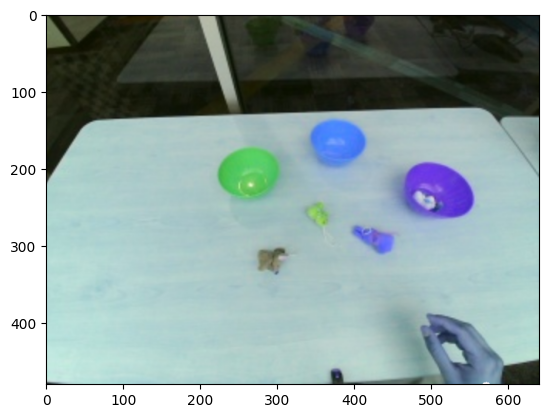

In [36]:
T = 100
hand_loc = h5py_file["data/demo_3/obs/ee_pose"][T][0:3]
print(hand_loc)
px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
#intrinsics=REALSENSE_INTRINSICS
#px_val = cam_frame_to_cam_pixels(hand_loc[None,:], intrinsics)
# px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
print("Pixel value", px_val)
frame = draw_dot_on_frame(h5py_file["data/demo_3/obs/front_img_1"][T], px_val, show=True)


In [16]:
intrinsics = np.array([[265.83575589493415, 0.0, 324.5832835740557,0], 
                                [0.0, 265.8940770981264, 244.23118856728662,0],
                                [0.0, 0.0, 1.0,0]])

In [18]:
# Robot frame is x (forward pos), y(left pos), z (up pos)
demo_name = "demo_22"
actions = h5py_file["data/"+demo_name+"/actions/"]
video = torch.zeros(h5py_file["data/"+demo_name+"/obs/front_img_1"].shape)
EE_POSE_VIDEO = True
ACTION_VIDEO = True
if EE_POSE_VIDEO:
    for t in range(video.shape[0]):
        # hand_loc = h5py_file["demo_0/obs/ee_pose"][t][0, 0:3]
        hand_loc = h5py_file["data/"+demo_name+"/obs/ee_pose"][t][0:3]
        # print(hand_loc)
        # px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
        px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
        # print("Pixel value", px_val)
        frame = draw_dot_on_frame(h5py_file["data/"+demo_name+"/obs/front_img_1"][t][:,:,[2,1,0]], px_val, show=False)
        video[t] = torch.from_numpy(frame)
    torchvision.io.write_video("hand_traj.mp4", video, fps=30)

if ACTION_VIDEO:
    for t in range(video.shape[0]):
        # hand_loc = h5py_file["demo_0/obs/ee_pose"][t][0, 0:3]
        hand_loc = actions[t]
        # print(hand_loc)
        # px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
        px_val = cam_frame_to_cam_pixels(actions[t].reshape(10,3), intrinsics)
        # print("Pixel value", px_val)
        frame = draw_dot_on_frame(h5py_file["data/"+demo_name+"/obs/front_img_1"][t][:,:,[2,1,0]], px_val, show=False)
        video[t] = torch.from_numpy(frame)
    torchvision.io.write_video("hand_traj_actions.mp4", video, fps=30)

In [19]:
%pwd

'/coc/flash7/pmathur39/EgoPlay/mimicplay/scripts/aloha_process'

In [18]:
video.shape

torch.Size([100, 480, 640, 3])

In [ ]:
video.shape

torch.Size([400, 480, 640, 3])

## Robot Data

## Calibration Data

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as Rot
import json
from simarUtils import *

In [5]:
# not processed
# calib = h5py.File("/coc/flash7/datasets/egoplay/aloha/stacking.hdf5")
# demo = calib["data/demo1"]

In [6]:
demo = h5py.File("/home/rl2-aloha/interbotix_ws/src/aloha/aloha_scripts/data/humanoid_stacking/robomimic/humanoid_stacking.hdf5", "r+")
demo=demo["demo0"]

In [7]:
nds(demo)

dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
actions: dict with keys:  <KeysViewHDF5 ['ee_pose']>
	ee_pose: (700, 7)
obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'front_img_1', 'front_img_2', 'gripper_position', 'joint_positions', 'joint_vel', 'wrist_img_1']>
	ee_pose: (700, 7)
	front_img_1: (700, 480, 640, 3)
	front_img_2: (700, 480, 640, 3)
	gripper_position: (700,)
	joint_positions: (700, 6)
	joint_vel: (700, 6)
	wrist_img_1: (700, 480, 640, 3)


In [10]:
calib["mask/train_small"] = calib["mask/train"][:1]
calib["mask/valid_small"] = calib["mask/train"][:1]

NameError: name 'calib' is not defined

## Visualize normalized Cam Frame EE pose / Actions

In [12]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+150][:, :3]
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)
print(points.round(3)[:5])
px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

NameError: name 'demo' is not defined

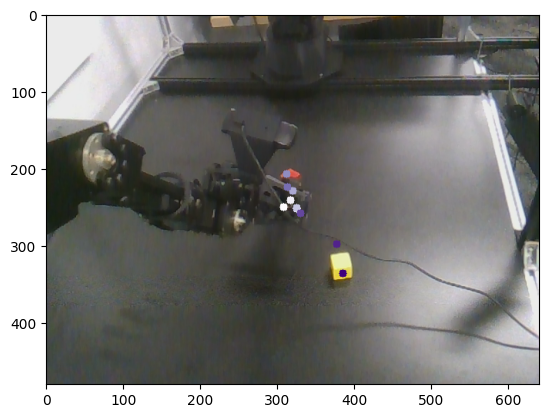

In [ ]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["actions"][T].reshape(-1, 3)
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)

px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

## Visualize Unnormalized Cam Frame EE_pose

(150, 3)
px val:  (150, 3)


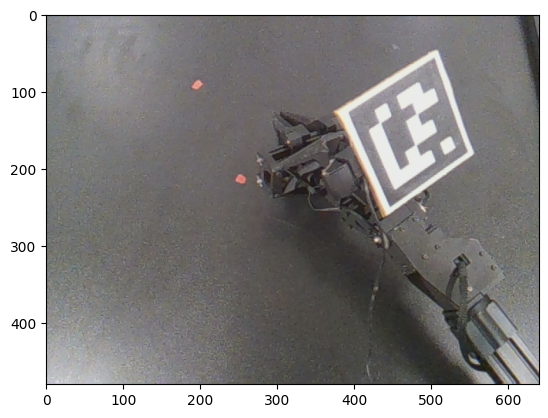

In [ ]:
T = 200
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+150][:, :3]
print(points.shape)
px_val = cam_frame_to_cam_pixels(points, intrinsics)
print("px val: ", px_val.shape)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

## Unnormalized Robot Frame EE_Pose

In [8]:
T_cam_base

array([[ 0.07 , -0.911,  0.407,  0.035],
       [ 0.997,  0.048, -0.063, -0.309],
       [ 0.038,  0.41 ,  0.911, -0.195],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

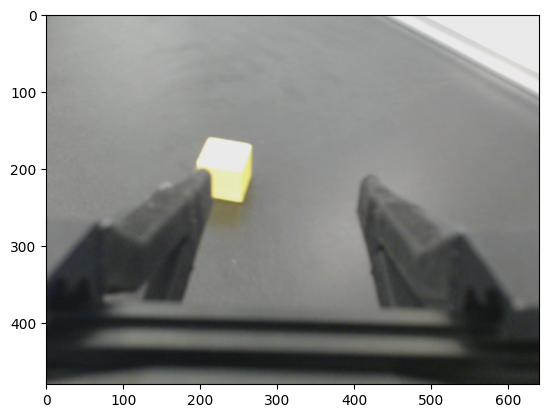

In [9]:
plt.imshow(demo["obs/wrist_img_1"][100])

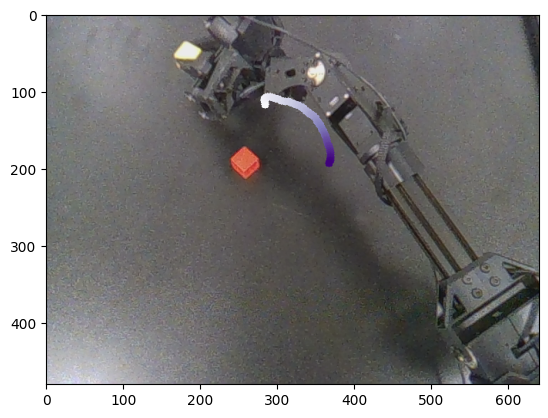

In [12]:
T = 250
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+50][:, :3]
px_val = ee_pose_to_cam_pixels(points, T_cam_base, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

In [25]:
imgs_tensor=torch.Tensor(*demo["obs/front_img_1"].shape)

for i in range(len(demo["obs/front_img_1"])):
    # inverted robot: (x forward, y right, z down) right handed frame
    # point = demo["obs/ee_pose"][T][:3][None, :]
    points = demo["obs/ee_pose"][i:i+50][:, :3]
    px_val = ee_pose_to_cam_pixels(points, T_cam_base, intrinsics)
    imgs_tensor[i]=torch.Tensor(draw_dot_on_frame(demo["obs/front_img_1"][i], px_val, show=False))
torchvision.io.write_video("viz.mp4",imgs_tensor,fps=30)

3d pos in base frame:  [ 0.37 -0.14 -0.02  1.  ]
3d pos in cam frame:  [0.07256679 0.18038024 0.61396421 1.        ]
2d pos cam frame:  [386.20740315 417.59020348   1.        ]
[386.20740315 417.59020348   1.        ]


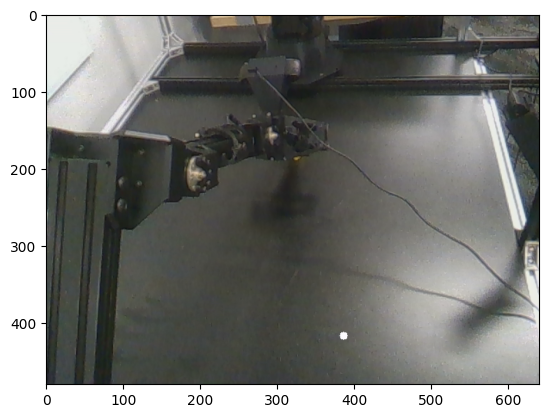

array([[[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 69,  69,  61],
        [ 67,  67,  59],
        [ 71,  71,  63]],

       [[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 69,  71,  62],
        [ 67,  69,  60],
        [ 69,  71,  62]],

       [[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 68,  72,  63],
        [ 69,  71,  62],
        [ 69,  71,  62]],

       ...,

       [[ 24,  27,  37],
        [ 37,  40,  50],
        [ 42,  41,  48],
        ...,
        [154, 157, 158],
        [157, 157, 159],
        [160, 160, 162]],

       [[ 31,  34,  44],
        [ 38,  41,  51],
        [ 40,  41,  50],
        ...,
        [154, 157, 158],
        [155, 158, 159],
        [157, 160, 161]],

       [[ 34,  38,  48],
        [ 38,  42,  52],
        [ 42,  43,  52],
        ...,
        [153, 156, 157],
        [155, 157, 161],
        [156, 158, 162]]

In [ ]:
T = 500
px_val = ee_pose_to_cam_pixels(np.array([0.37, -0.14, -0.02]), T_cam_base, intrinsics)
print(px_val)
draw_dot_on_frame(demo["obs/front_img_1"][T], [px_val])

## Raw Aloha Data

In [1]:
from modern_robotics import FKinSpace

In [4]:
demo = h5py.File("/coc/flash7/datasets/egoplay/humanoidStacking/rawAloha/episode_12.hdf5", "r+")
nds(demo)

dict with keys:  <KeysViewHDF5 ['action', 'observations']>
action: (700, 14)
observations: dict with keys:  <KeysViewHDF5 ['effort', 'images', 'qpos', 'qvel']>
	effort: (700, 14)
	images: dict with keys:  <KeysViewHDF5 ['cam_high', 'cam_low', 'cam_right_wrist']>
		cam_high: (700, 480, 640, 3)
		cam_low: (700, 480, 640, 3)
		cam_right_wrist: (700, 480, 640, 3)
	qpos: (700, 14)
	qvel: (700, 14)


[-0.38656318 -0.4249127   0.64887387  0.4893399  -0.11351458 -0.6718836 ]
[[ 0.89775962  0.39709208  0.19064509  0.36548117]
 [-0.4229108   0.8980633   0.12094943 -0.15893802]
 [-0.1231833  -0.18920938  0.97417949  0.33649676]
 [ 0.          0.          0.          1.        ]]
[-0.38042724 -0.4310486   0.65040785  0.4893399  -0.1119806  -0.6718836 ]
[[ 0.90100488  0.39152211  0.18681713  0.36515358]
 [-0.41688947  0.90055812  0.12328116 -0.15603768]
 [-0.11997238 -0.18895902  0.97462871  0.33798016]
 [ 0.          0.          0.          1.        ]]
[-0.37429133 -0.43565056  0.65194184  0.4893399  -0.11044662 -0.6718836 ]
[[ 0.90403212  0.38566535  0.18435878  0.36510197]
 [-0.41077428  0.90312416  0.12502498 -0.15326432]
 [-0.11828106 -0.18875645  0.97487466  0.33884706]
 [ 0.          0.          0.          1.        ]]
[-0.36508745 -0.44332045  0.6534758   0.4893399  -0.10737866 -0.6718836 ]
[[ 0.9087269   0.37668313  0.17979222  0.3649029 ]
 [-0.40126575  0.90698981  0.12788778 

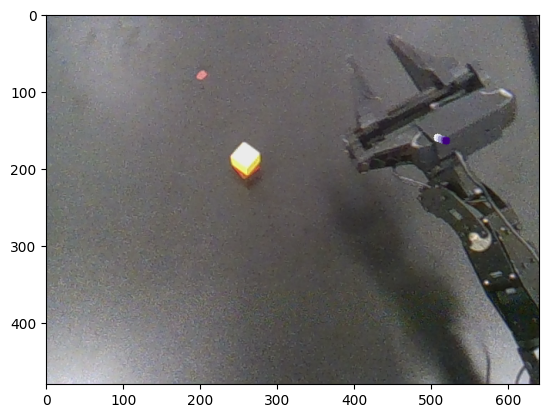

In [5]:
T = 537
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
rollout = 5
joint_positions = demo["action"][T:T+rollout][:, 7:13]
points = np.zeros((rollout, 3))
for i in range(rollout):
    M = np.array([[1.0, 0.0, 0.0, 0.536494],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.42705],
                [0.0, 0.0, 0.0, 1.0]])

    Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T
    print(joint_positions[i])
    T_obs = FKinSpace(M, Slist, joint_positions[i])
    print(T_obs)
    points[i] = T_obs[:3, 3]
px_val = ee_pose_to_cam_pixels(points, EXTRINSICS["humanoidJan19"], REALSENSE_INTRINSICS)
plt.imshow(draw_dot_on_frame(demo["observations/images/cam_high"][T], px_val, show=False))

# IK ground up

In [ ]:
import h5py
import matplotlib.pyplot as plt

In [ ]:
file = h5py.File("/coc/flash7/skareer6/episode_0.hdf5", "r+")
file["observations/qpos"].shape
joint_poses = file["observations/qpos"][0:700]

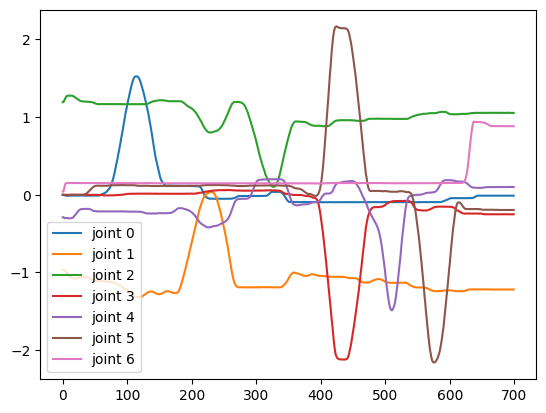

In [ ]:
# plt.plot(joint_poses)
#plot each joint in joint_poses and label it in the legend
joint_poses = joint_poses[:, 0:7]
for i in range(joint_poses.shape[1]):
    plt.plot(joint_poses[:,i], label="joint {}".format(i))
plt.legend()
plt.show()

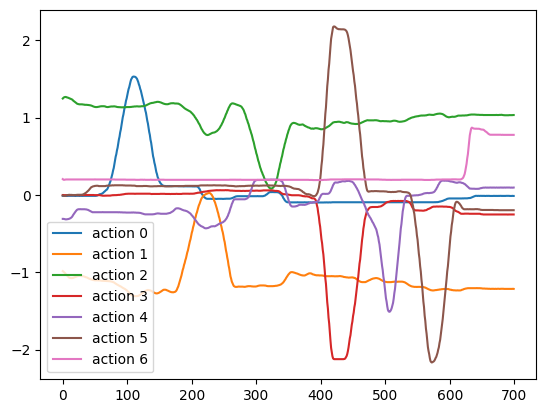

In [ ]:
# plot same for actions
actions = file["action"][:, :7]
for i in range(actions.shape[1]):
    plt.plot(actions[:,i], label="action {}".format(i))
plt.legend()
plt.show()

## Next check the poses for 2 known positions

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from modern_robotics import FKinSpace

In [ ]:
file = h5py.File("/coc/flash7/skareer6/touch_points.hdf5", "r+")

In [ ]:
M = np.array([[1.0, 0.0, 0.0, 0.536494],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.42705],
    [0.0, 0.0, 0.0, 1.0]])

Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T

In [ ]:
joint_poses = file["observations/qpos"][0:700]

[[ 0.72 -0.12  0.69  0.34]
 [ 0.13  0.99  0.04  0.09]
 [-0.68  0.06  0.73  0.03]
 [ 0.    0.    0.    1.  ]]


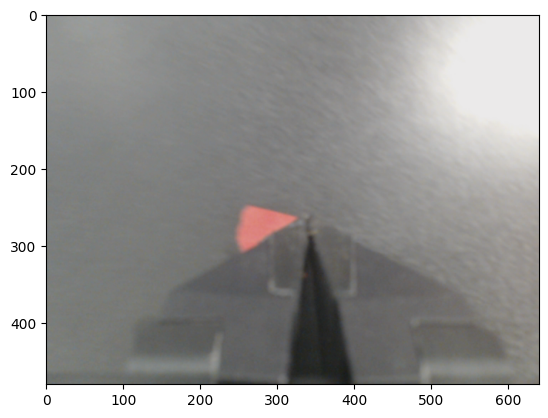

In [ ]:
T = 200
# print joint pos and show camera image
joint_poses = joint_poses[:, 0:7]
# print(joint_poses[T])
plt.imshow(file["observations/images/cam_left_wrist"][T])
trans = FKinSpace(M, Slist, joint_poses[T][:6])
print(trans.round(2))